# CME 241 -- Assigment 4

## Question 2: Frog Croaking Revisited

In [19]:
import matplotlib.pyplot as plt
import numpy as np

from rl.distribution import Categorical, Choose, Constant
from rl.markov_process import StateReward
from rl.markov_decision_process import FiniteMarkovDecisionProcess
from rl.dynamic_programming import value_iteration, policy_iteration

In [2]:
def get_frog_mdp(n: int) -> FiniteMarkovDecisionProcess:
    """Construct the frog-problem MDP for a given n."""
    
    rewards = {s: 0 for s in range(n)}
    rewards[n] = +1
    
    def _get_state_rewards(state: int, action: str) -> StateReward:
        """Return the distribution of rewards."""
        if action == 'A':
            return Categorical({
                (state - 1, rewards[state - 1]): state / n,
                (state + 1, rewards[state + 1]): (n - state) / n
            })
        if action == 'B':
            return Choose({
                (i, rewards[i]) for i in range(n + 1) if i != state
            })
        raise RuntimeError(f"Uh oh, should not be reaching here!")
    
    actions = 'AB'
    state_action_mapping = {0: None, n: None}
    for s in range(1, n):
        state_action_mapping[s]= {}
        for a in actions:
            state_action_mapping[s][a] = _get_state_rewards(s, a)
    return FiniteMarkovDecisionProcess(state_action_mapping)

In [24]:
ns = [n for n in range(20, 120, 10)]
vi_steps = []
pi_steps = []

for n in ns:
    mdp = get_frog_mdp(n)

    # first we see how many steps it takes value iteration to converge
    old = np.random.randn(n - 1)
    for i, v in enumerate(value_iteration(mdp, gamma=1.0)):
        solution = np.array([v[j] for j in range(1, n)])
        if np.linalg.norm(solution - old) < 1e-5:
            vi_steps.append(i)
            break
        old = solution

    # then we try policy iteration
    old = np.random.randn(n - 1)
    for i, (v, p) in enumerate(policy_iteration(mdp, gamma=1.0)):
        solution = np.array([v[j] for j in range(1, n)])
        if np.linalg.norm(solution - old) < 1e-5:
            pi_steps.append(i)
            break
        old = solution

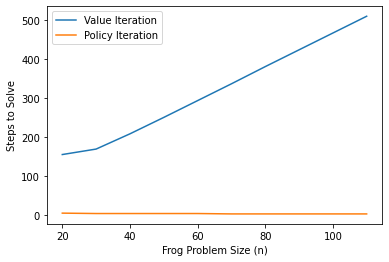

In [25]:
plt.plot(ns, vi_steps, label="Value Iteration")
plt.plot(ns, pi_steps, label="Policy Iteration")

plt.xlabel("Frog Problem Size (n)")
plt.ylabel("Steps to Solve")

plt.legend()
plt.show()

## Question 3: Job-Hpping and Wages-Utility Maximization

The state space of this MDP is $\mathcal{S} = \{s \mid s = 1, 2, ..., n, n+1\}$ where $1 \leq s \leq n$ are states for each of the $n$ jobs, and $s = n + 1$ is the unemployed state.

The action space can be defined as $\mathcal{A} = \{c, r\}$ where $c$ represents accepting a new job and $r$ represents rejecting a new job.

The transition function $\mathcal{P}(s, a, s')$ can be computed as $\mathbb{P}\left[S_{t+1} = s' \mid S_t = s, A = a \right]$.

$$\mathcal{P}(s, a, s) = 1 - \alpha : \forall s \neq n + 1, a \in \mathcal{A}$$
$$\mathcal{P}(s, a, s') = 0 : \forall s \neq s', s' \neq n + 1, a \in \mathcal{A}$$
$$\mathcal{P}(s, a, n + 1) = \alpha : \forall s \neq n + 1, a \in \mathcal{A}$$
$$\mathcal{P}(n + 1, c, s') = p_{s'} : \forall s' \neq n + 1$$
$$\mathcal{P}(n + 1, r, s')= 0.0 : \forall s' \neq n + 1$$
$$\mathcal{P}(n + 1, r, n + 1) = 1.0$$
$$\mathcal{P}(n + 1, c, n + 1)= 0.0$$

The reward function $\mathcal{R}(s, a)$ is:

$$\mathcal{R}(s, a) = \log(w_s) : \forall s \neq n + 1, \forall a \in \mathcal{A}$$
$$\mathcal{R}(n + 1, c) = \log \left(\mathbb{E}\left[w_{s'} \mid S_{t+1} = s'\right]\right) = \log \left(\underset{1 \leq i \leq n}{\sum}p_i w_i \right)$$
$$\mathcal{R}(n + 1, r) = \log(w_{0})$$

Now we can write the general Bellman Optimality Equation:

$$ \pmb{V}^*(s) = \underset{a \in \mathcal{A}}{\max}\left\{ \mathcal{R}(s, a) 
    + \gamma \cdot \underset{s' \in \mathcal{S}}{\sum} \mathcal{P}(s, a, s') \cdot \pmb{V}^*(s') \right\}
$$

and solve for $\pmb{V}^*$ with the Value Iteration algorithm. From there, we can back out $\pi^*$, the optimal (deterministic) policy.

$$\pmb{Q}^*(s,a) = \mathcal{R}(s,a) + \gamma \cdot \underset{s' \in \mathcal{S}}{\sum}\mathcal{P}(s, a, s') \cdot \pmb{V}^*(s')$$
$$\pi^*(s) = \underset{a \in \mathcal{A}}{\arg \max} \left\{ \pmb{Q}^*(s,a) \right\}$$

In [1]:
from dataclasses import dataclass, field
from typing import (
    Mapping,
    List, 
    Generic, 
    TypeVar, 
    Set
)

import numpy as np
from pprint import pprint

In [2]:
S = TypeVar("S")

@dataclass
class WageMaximizer(Generic[S]):
    """
    Solves the Wage-Utility Maximization problem via the 
    Bellman Optimality Equation.
    """
    gamma: float
    alpha: float

    employed_states: List[S]
    unemployed_state: S
    
    employed_wages: np.array
    unemployed_wage: float
        
    probs: np.array
        
    def __post_init__(self) -> None:
        """Some more set up."""
        self._validate()
        self.actions: Set[str] = {'c', 'r'}
        self._state_probs = {
            s: p for s, p in 
            zip(self.employed_states, self.probs)
        }
        self._state_wages = {
            s: r for s, r in 
            zip(self.employed_states, self.employed_wages)
        }
        
    def _validate(self) -> None:
        """Validate given problem parametersl."""
        a = len(self.employed_wages)
        b = len(self.probs)
        c = len(self.employed_states)
        if not (a == b == c):
            raise ValueError("Check parameter lengths.")
        if any(x <= 0 for x in self.employed_wages + [self.unemployed_wage]):
            raise ValueError("Must have positive wages.")
        if self.probs.sum() != 1:
            raise ValueError("Check transition probabilities.")
        if self.unemployed_state in self.employed_states:
            raise ValueError(
                f"{self.unemployed_state} cannot also be an employed_state"
            )
    
    @property
    def states(self) -> List[S]:
        return self.employed_states + [self.unemployed_state]
    
    def P(self, state: S, action: str, next_state: S) -> float:
        """Return the (s, a, s') transition probability"""
        if action not in self.actions:
            raise ValueError(f"{a=} is an invalid action")
        m: S = self.unemployed_state
        if (state, action, next_state) == (m, 'c', m):
            return 0
        if (state, action, next_state) == (m, 'r', m):
            return 1
        if (state, action) == (m, 'r'):
            return 0
        if (state, action) == (m, 'c'):
            return self._state_probs[next_state]
        if next_state == m:
            return self.alpha
        if state == next_state:
            return 1 - self.alpha
        return 0
    
    def R(self, state: S, action: str) -> float:
        """Return the expected reward of (s, a)."""
        if action not in self.actions:
            raise ValueError(f"{a=} is an invalid action")
        m: S = self.unemployed_state
        if (state, action) == (m, 'r'):
            return np.log(self.unemployed_wage)
        if (state, action) == (m, 'c'):
            return np.log(self.employed_wages @ self.probs)
        return np.log(self._state_wages[state])
    
    def value_iteration(self) -> np.array:
        """Compute the optimal value function."""
        vk = np.zeros(len(self.states))
        
        def maximize(s: S, vfunc: np.array) -> float:
            """Maximize value function for a state over actions."""
            maximum = float("-inf")
            for a in self.actions:
                _sum = sum(
                    self.P(s, a, s_) * vfunc[j] 
                    for j, s_ in enumerate(self.states)
                )
                val = self.R(s, a) + self.gamma * _sum
                maximum = max(val, maximum)
            return maximum
        
        while True:
            improvement = vk.copy()
            for i, state in enumerate(self.states):
                improvement[i] = maximize(state, vk)
            if np.linalg.norm(improvement - vk) < 1e-5:
                return {s: v for s, v in zip(solver.states, improvement)}
            vk = improvement
            
    def find_optimal_policy(self) -> Mapping[S, str]:
        """Find the an optimal deterministic policy."""
        pi = {}
        v_star = self.value_iteration()
        
        def q_star(s: S, a: str) -> float:
            """Compute Q^* for a (state, action) pair."""
            return (self.R(s, a) + self.gamma * 
                    sum(self.P(s, a, s_) * v_star[s_] 
                        for s_ in self.states))
        
        for s in self.states:
            _max = float("-inf")
            action = None
            for a in self.actions:
                if q_star(s, a) > _max:
                    _max = q_star(s, a)
                    action = a
            pi[s] = action
        return pi
                

In [3]:
gamma: float = 0.1
alpha: float = 0.1

employed_states: List[int] = [1, 2, 3, 4, 5]
unemployed_state: int = 6

employed_wages: List[float] = [2, 1, 4, 7, 3]
unemployed_wage: float = 1
    
probs: List[float] = [0.1, 0.2, 0.4, 0.1, 0.2]
    
solver = WageMaximizer[int](
    gamma=gamma,
    alpha=alpha,
    employed_states=employed_states,
    unemployed_state=unemployed_state,
    employed_wages=np.array(employed_wages),
    unemployed_wage=unemployed_wage,
    probs=np.array(probs)
)
v_star = solver.value_iteration()
v_star

{1: 0.7760895874094604,
 2: 0.014389425423822473,
 3: 1.5377897493950983,
 4: 2.1527521243062777,
 5: 1.221655618964289,
 6: 1.3094432712224158}

In [4]:
# Note that for all the 'employed' states, it doesn't matter what our
# policy is because our action does not affect the transition
# probabilities
opt_policy = solver.find_optimal_policy()
opt_policy

{1: 'r', 2: 'r', 3: 'r', 4: 'r', 5: 'r', 6: 'c'}

## Question 4: Two-Stores Inventory Control

The states of this problem can be represented as four-tuples, $\langle\alpha_0, \beta_0, \alpha_1, \beta_1\rangle$. The actions are three-tuples $\langle\theta_0, \delta, \theta_1\rangle$, where $\theta_i$ is how much inventory store $i$ ordered from the supplier and $\delta$ is how much inventory will be shifted from store $0$ to store $1$. Note that $\delta$ can be negative.

From this, we can see that the state transitions $s \to s'$ take the form 

$$\langle\alpha_0, \beta_0, \alpha_1, \beta_1\rangle \to \langle\max\left\{\alpha_0 + \beta_0 - \delta - X_0, 0\right\}, \theta_0, \max\left\{\alpha_1 + \beta_1 + \delta - X_1, 0\right\}, \theta_1\rangle$$

for a given action tuple and where

$$\mathbb{P}[X_i = x_i] =  \frac{{e^{ - \lambda_0 } \lambda_0^{x_i} }}{{x_i!}}$$

We will define the rewards of our two store MDP as the sum of the rewards of the individual one store MDPs.

$$
\mathcal{R}\left( \langle\alpha_0, \beta_0, \alpha_1, \beta_1\rangle, a\right) = \mathcal{R}_0\left(\langle\alpha_0, \beta_0\rangle, a\right) + \mathcal{R}_1\left(\langle\alpha_1, \beta_1\rangle, a\right)
$$

<!-- Since store $0$ and store $1$ face independent demands $x_0$, $x_1$ on any given day, we can compute the joint probability of demands as 

$$
    \mathbb{P}[X_0 = x_0, X_1 = x_1] = \mathbb{P}[X_0 = x_0] \cdot \mathbb{P}[X_1 = x_1] 
$$

This leads us to the observation

$$\mathcal{P}\left( \langle\alpha_0, \beta_0, \alpha_1, \beta_1\rangle, a, \langle\alpha_0', \beta_0', \alpha_1', \beta_1'\rangle \right) = \mathcal{P}_0\left(\langle\alpha_0, \beta_0\rangle, a, \langle\alpha_0', \beta_0'\rangle\right) \cdot \mathcal{P}_1\left(\langle\alpha_1, \beta_1\rangle, a, \langle\alpha_1', \beta_1'\rangle\right)$$

where $\mathcal{P}_i(s_i, a, s_i')$ represent the dynamics of the single store MDP.  -->

We will now define $\mathcal{P}_i$ where $\mathcal{P}_i(s_i, a, s_i')$ represent the dynamics of a single store MDP. We can then directly compute the rewards at each $s'$. Every morning, the opening inventory in store $i$ is $\alpha_i + \beta_i - \delta\pmb{I}$ where $\pmb{I}$ is an indicator variable (1 for $i=0$, -1 for $i=1$).

If $\alpha_i + \beta_i - \delta\pmb{I} >= x_i$:
- $\mathcal{P}_i(s, a, s') = \mathbb{P}[X_i = x_i]$ 
- $R_i(s') = -h_i\alpha_i$

If $\alpha_i + \beta_i - \delta\pmb{I} < x_i$:
- $\mathcal{P}_i(s, a, s'=0) = \mathbb{P}[X_i > \alpha_i + \beta_i - \delta\pmb{I}]$ 
<!-- - $\mathcal{R}_i(s'=0) = -h_i\alpha_i - p_i (x_i - \alpha_i + \beta_i - \delta\pmb{I})$ -->
- $\mathcal{R}_i(s'=0) = -h_i\alpha_i - p_i \sum_{j = \alpha_i + \beta_i - \delta\pmb{I} + 1}^\infty f(j) \cdot(j - (\alpha_i + \beta_i - \delta\pmb{I}))$

where $h$ and $p$ are holding and stockout costs, respectively. From these, we can express

$$\mathcal{R}_i(s, a) = K_1\theta_i + \frac{K_2}{2}\delta + \sum_{s'} \mathcal{P}_i(s, a, s') \cdot R_i(s')$$

and compute $\mathcal{R}(s, a) = \mathcal{R}_0(s, a) + \mathcal{R}_1(s, a)$.

In [5]:
from dataclasses import dataclass
from typing import Tuple, Iterable, Dict
import itertools as it

from scipy.stats import poisson

from rl.distribution import Categorical
from rl.markov_decision_process import (
    FiniteMarkovDecisionProcess as fMDP,
    StateActionMapping
)
from rl.dynamic_programming import value_iteration_result
from rl.chapter3.simple_inventory_mdp_cap import InventoryState

In [6]:
State = Tuple[InventoryState, InventoryState]
Action = Tuple[int, int, int]

@dataclass
class TwoStoreInventory(fMDP[State, Action]):
    """Representation of the Two-Store Inventory Control problem."""
    
    capacities: Tuple[int, int]
    lambdas: Tuple[float, float]
    holding_costs: Tuple[float, float]
    stockout_costs: Tuple[float, float]
    supplier_cost: float
    transfer_cost: float
        
    def __post_init__(self) -> None:
        """Instantiate base class with proper distributions."""
        super().__init__(mapping=self._map_transitions())
        
    def _get_probability_reward(
        self, 
        s: State, 
        a: Action, 
        x: int
    ) -> Tuple[float, float]:
        """Compute joint probability of this transition."""
        delta: int = a[1]
            
        def _prob_reward(i: int) -> float:
            """Compute probability of single store MDP transition."""
            _map = {0: 1, 1: -1}
            indicator = _map[i]
            Poiss = poisson(self.lambdas[i])
            ip = s[i].inventory_position()
            if ip - delta * indicator >= x[i]:
                p = Poiss.pmf(x[i])
                r = -self.h[i] * s[i].on_hand
                return p, r
            p = Poiss.cdf(x[i])
            r = -self.h[i] * s[i].on_hand
            r -= self.p[i] * self.lambdas[i] * (1 - Poiss(ip - 1))
            r -= ip * (1 - Poiss(ip))
            return p, r

        P, R = _prob_reward(0)
        P_, R_ = _prob_reward(1)
        return P * P_, R + R_
      
    
    def _orders_filled(self, _state: State, _action: Action) -> Tuple[int, int]:
        """We can create next states from enumeration of filled orders."""
        delta: int = _action[1]

        def _orders(i: int) -> int:
            """Possible orders for single store."""
            _map = {0: 1, 1: -1}
            indicator = _map[i]
            ip: int = _state[i].inventory_position()
            total_sellable: int = ip - delta * indicator
            for j in range(total_sellable + 1):
                yield j

        for a, b in it.product(_orders(0), _orders(1)):
            yield a, b 
                
    def _map_transitions(self) -> StateActionMapping[State, Action]:
        """Construct the transition probability table."""
        StateRewardPair = Tuple[State, float]
        mapping: Dict[State, Dict[Action, Categorical[StateRewardPair]]] = {}
                    
        for state in self.all_states:
            action_to_dist: Dict[Action, Categorical[StateRewardPair]] = {}
            for action in self.available_actions(state):
                state_reward_to_prob: Dict[StateRewardPair, float] = {}
                for demand in self._orders_filled(state, action):
                    P, R = self._get_probability_reward(state, action, demand)
                    state_ = self._construct_next_state(state, action, demand)
                    state_reward_to_prob[(state_, R)] = P
                action_to_dist[action] = Categorical(state_reward_to_prob)
            mapping[state] = action_to_dist
        return mapping
    
    def _construct_next_state(
        self,
        _state: State, 
        _action: Action, 
        _demand: Tuple[int, int]
    ) -> State:
        """Form the next state."""
        delta: int = _action[1]
        x = InventoryState(
            _state[0].inventory_position() - delta - _demand[0],
            _action[0]
        )
        y = InventoryState(
            _state[1].inventory_position() + delta - _demand[1],
            _action[2]
        )
        return x, y
                
    @property
    def cap(self) -> Tuple[int, int]:
        """Short alias."""
        return self.capacities
    
    @property
    def h(self) -> Tuple[float, float]:
        """Short alias."""
        return self.holding_costs
    
    @property
    def p(self) -> Tuple[float, float]:
        """Short alias."""
        return self.stockout_costs

    @property
    def all_states(self) -> Iterable[State]:
        """Yields all states of this MDP."""
        
        def _states(i: int) -> Iterable[InventoryState]:
            """Generate all states given a single store capacity."""
            for alpha in range(self.cap[i] + 1):
                for beta in range(self.cap[i] + 1 - alpha):
                    yield InventoryState(alpha, beta)
                    
        for a, b in it.product(_states(0), _states(1)):
            yield a, b
            
    def available_actions(self, s: State) -> Iterable[Action]:
        """Given a current state, yield possible next actions."""
        ips = s[0].inventory_position(), s[1].inventory_position()
        n_moveable_up = min(s[0].on_hand, self.cap[1] - ips[1])
        n_moveable_down = min(s[1].on_hand, self.cap[0] - ips[0])
        
        for transfer in range(-n_moveable_down, n_moveable_up + 1):
            for a in range(self.cap[0] - ips[0] + transfer + 1):
                for b in range(self.cap[1] - ips[1] - transfer + 1):
                    msg = f"{s}, {transfer=}"
                    assert transfer <= s[0].on_hand, msg
                    assert ips[0] - transfer <= self.cap[0], msg
                    assert -transfer <= s[1].on_hand, msg
                    assert ips[1] + transfer <= self.cap[1], msg
                    yield a, transfer, b
                
                      
    def possible_next_states(s: State, a: Action) -> Iterable[State]:
        """Yield all possible next states for a given s, a pair."""
        
        def _single_next_states(on_hand: int, ordered: int) -> InventoryState:
            """Account for all possible daily demands."""
            for demand in range(on_hand + 1):
                yield InventoryState(on_hand - demand, ordered)
        
        order0, transfer, order1 = a
        morning_inventory0 = s[0].inventory_position() - transfer
        morning_inventory1 = s[1].inventory_position() + transfer
        for a, b in it.product(
            _next_states(morning_inventory0, order0),
            _next_states(morning_inventory1, order1)
        ):
            yield a, b

In [7]:
mdp = TwoStoreInventory(
    capacities=(3, 2),
    lambdas=(1, 3),
    holding_costs=(2, 3),
    stockout_costs=(7, 6),
    supplier_cost=8,
    transfer_cost=2,
)
opt_vf, opt_policy = value_iteration_result(mdp, gamma=0.9)

In [8]:
opt_vf

{(InventoryState(on_hand=0, on_order=0),
  InventoryState(on_hand=0, on_order=0)): 0.0,
 (InventoryState(on_hand=0, on_order=0),
  InventoryState(on_hand=0, on_order=1)): -0.8709674523163493,
 (InventoryState(on_hand=0, on_order=0),
  InventoryState(on_hand=0, on_order=2)): -2.0857377676002486,
 (InventoryState(on_hand=0, on_order=0),
  InventoryState(on_hand=1, on_order=0)): -3.870967452316349,
 (InventoryState(on_hand=0, on_order=0),
  InventoryState(on_hand=1, on_order=1)): -5.085737767600248,
 (InventoryState(on_hand=0, on_order=0),
  InventoryState(on_hand=2, on_order=0)): -8.08573776760025,
 (InventoryState(on_hand=0, on_order=1),
  InventoryState(on_hand=0, on_order=0)): -1.2919349046326987,
 (InventoryState(on_hand=0, on_order=1),
  InventoryState(on_hand=0, on_order=1)): -2.2015801042334386,
 (InventoryState(on_hand=0, on_order=1),
  InventoryState(on_hand=0, on_order=2)): -3.4588611763192936,
 (InventoryState(on_hand=0, on_order=1),
  InventoryState(on_hand=1, on_order=0)): -

In [9]:
opt_policy

For State (InventoryState(on_hand=0, on_order=0), InventoryState(on_hand=0, on_order=0)):
  Do Action (0, 0, 0) with Probability 1.000
For State (InventoryState(on_hand=0, on_order=0), InventoryState(on_hand=0, on_order=1)):
  Do Action (0, 0, 0) with Probability 1.000
For State (InventoryState(on_hand=0, on_order=0), InventoryState(on_hand=0, on_order=2)):
  Do Action (0, 0, 0) with Probability 1.000
For State (InventoryState(on_hand=0, on_order=0), InventoryState(on_hand=1, on_order=0)):
  Do Action (0, 0, 0) with Probability 1.000
For State (InventoryState(on_hand=0, on_order=0), InventoryState(on_hand=1, on_order=1)):
  Do Action (0, 0, 0) with Probability 1.000
For State (InventoryState(on_hand=0, on_order=0), InventoryState(on_hand=2, on_order=0)):
  Do Action (0, 0, 0) with Probability 1.000
For State (InventoryState(on_hand=0, on_order=1), InventoryState(on_hand=0, on_order=0)):
  Do Action (0, 0, 0) with Probability 1.000
For State (InventoryState(on_hand=0, on_order=1), Inven